# **Predicting emissions using the _ARIMA_ model**

## Imports

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import sys
sys.path.append("../src")
from utils import *

## Importing timeseries

In [16]:
# Read preprocessed data
data_processed = pd.read_csv('../data/processed/final_data.csv', index_col='Unnamed: 0', parse_dates=['date_etablissement_dpe'])

In [17]:
# Split data according to category
data = split(data_processed)

In [18]:
ts = {key: {freq: extract_ts(df, freq) for freq in ['D', 'W', 'ME']} for key, df in data.items()}

## Plotting timeseries

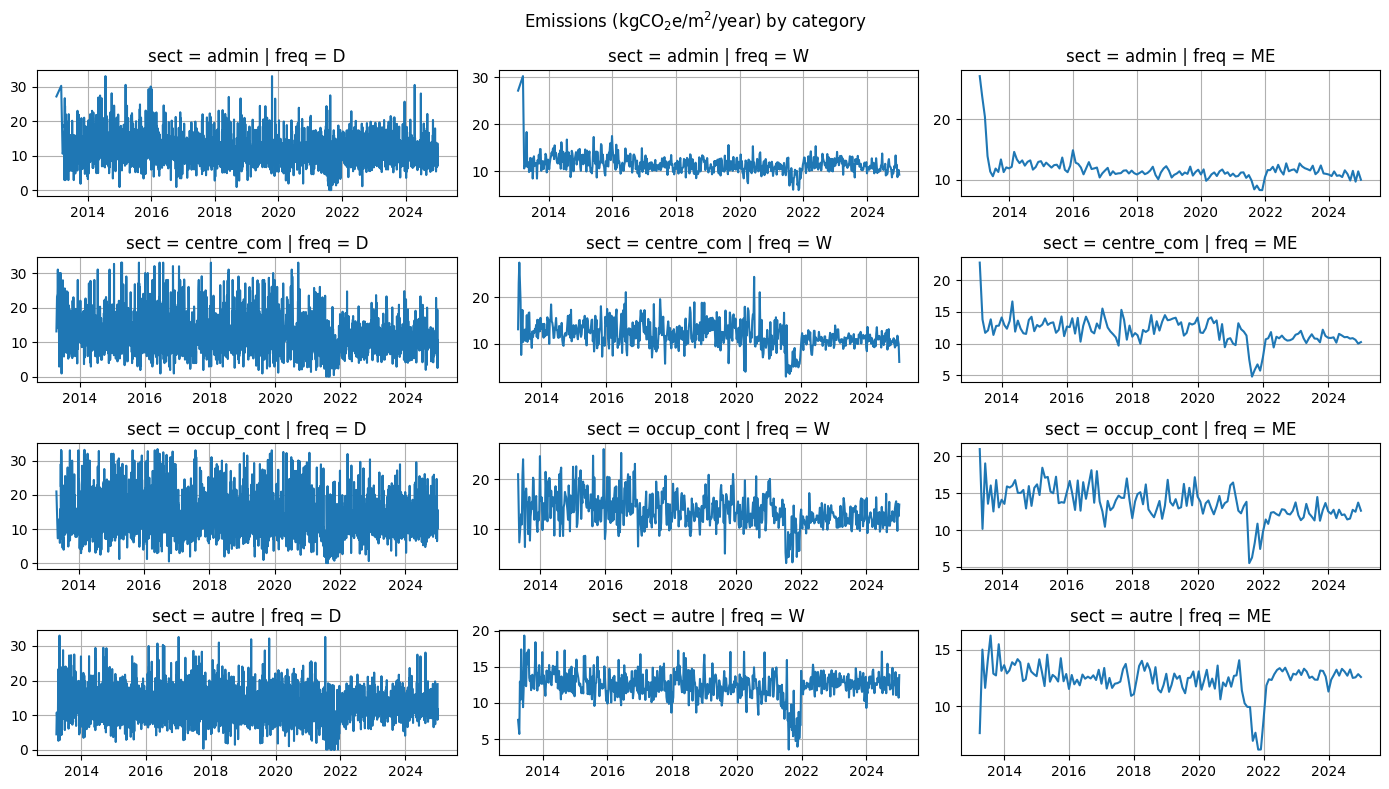

In [ ]:
fig, axs = plt.subplots(4, 3, figsize=(14, 8))

for i, sect in enumerate(ts):
    for j, freq in enumerate(ts[sect]):
        axs[i, j].plot(ts[sect][freq])
        axs[i, j].set_title(f'sect = {sect} | freq = {freq}')
        axs[i, j].grid(True)

fig.suptitle('Emissions (kgCO$_2$e/m$^2$/year) by category')
plt.tight_layout()
plt.show()

## Plotting differentiated timeseries

In [46]:
ts_diff = {sect: {freq: ts[sect][freq].diff().dropna() for freq in ts[sect]} for sect in ts}

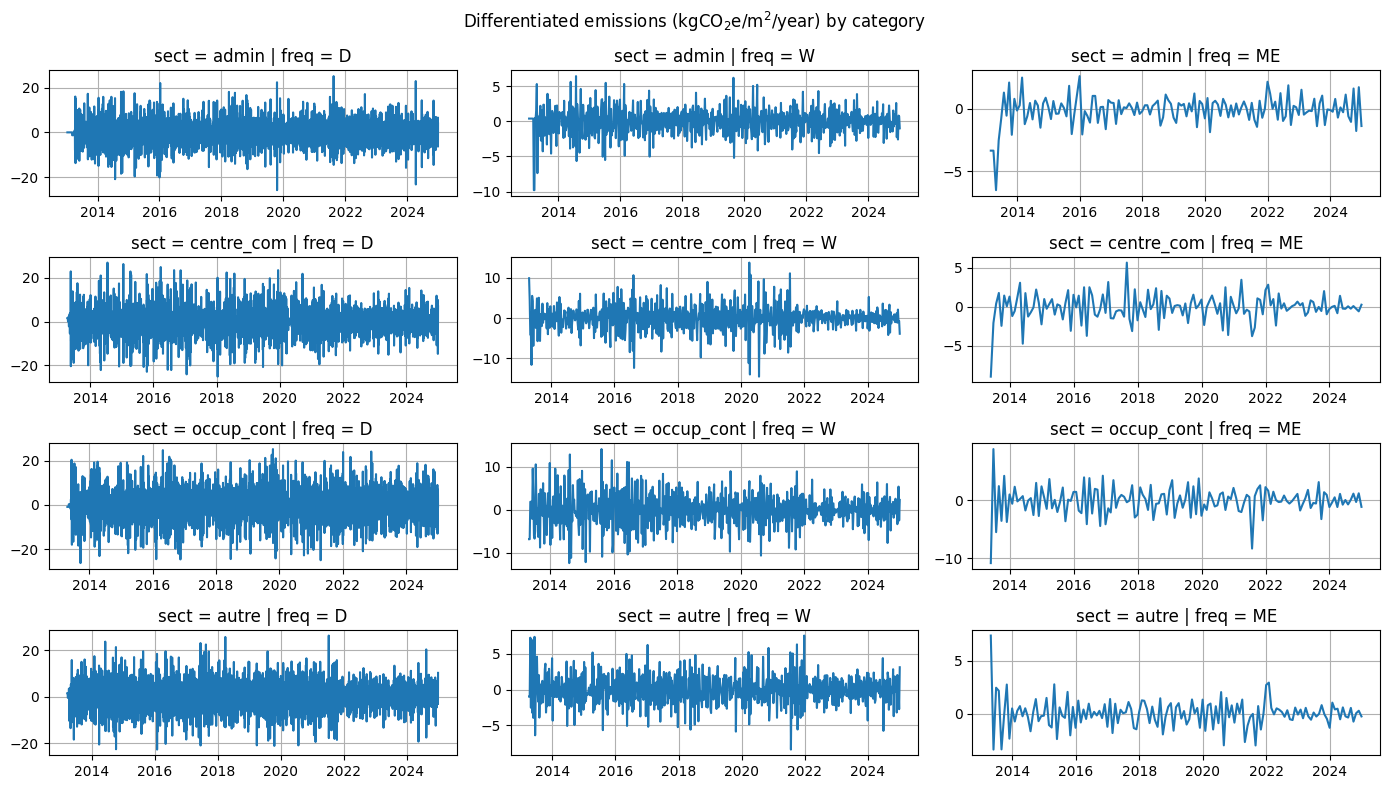

In [ ]:
fig, axs = plt.subplots(4, 3, figsize=(14, 8))

for i, sect in enumerate(ts_diff):
    for j, freq in enumerate(ts_diff[sect]):
        axs[i, j].plot(ts_diff[sect][freq])
        axs[i, j].set_title(f'sect = {sect} | freq = {freq}')
        axs[i, j].grid(True)

fig.suptitle('Differentiated emissions (kgCO$_2$e/m$^2$/year) by category')
plt.tight_layout()
plt.show()

## Stationarity testing via the _Dickey-Fuller_ test

In [52]:
dft = {}

for sect in ts_diff:
    dft[sect] = {}
    for freq in ts_diff[sect]:
        dft[sect][freq] = adfuller(ts_diff[sect][freq])[1]

dft_df = pd.DataFrame(dft)
dft_df

,admin,centre_com,occup_cont,autre
D,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
W,1.323273e-16,1.208407e-25,7.193129e-12,3.711787e-21
ME,9.497178e-20,3.563808e-11,3.791392e-09,0.000000e+00


All the p-values are very small. Which confirms the stationarity of the timeseries after one differentiation ($d=1$).

## Parameter estimation using the ACF and PCF

### Partial auto-correlation function (PACF)

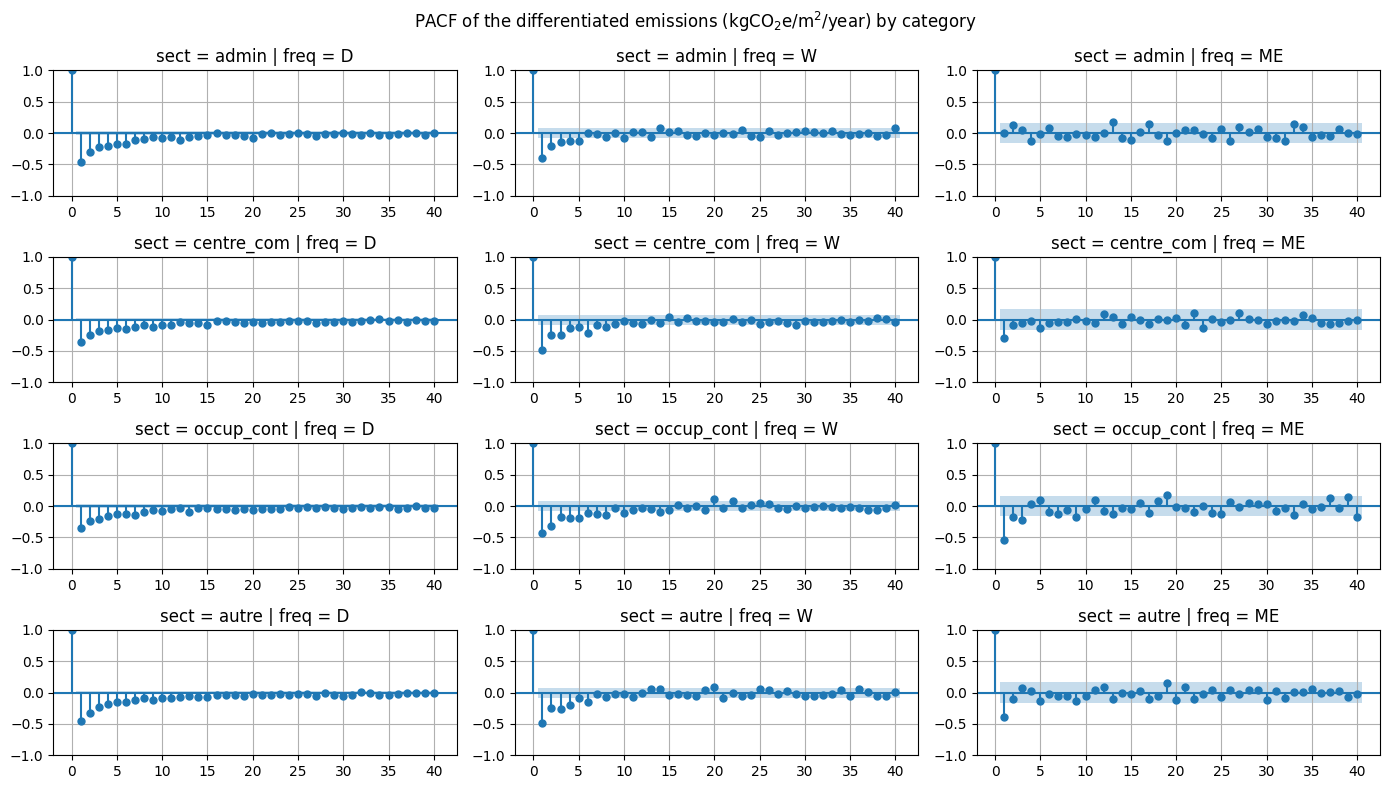

In [57]:
fig, axs = plt.subplots(4, 3, figsize=(14, 8))

for i, sect in enumerate(ts_diff):
    for j, freq in enumerate(ts_diff[sect]):
        plot_pacf(ts_diff[sect][freq], ax=axs[i, j], lags=40)
        axs[i, j].set_title(f'sect = {sect} | freq = {freq}')
        axs[i, j].grid(True)

fig.suptitle('PACF of the differentiated emissions (kgCO$_2$e/m$^2$/year) by category')
plt.tight_layout()
plt.show()

The PACF plots indicate that the parameter $p$ should be $0$. As it shows an exponential decay. Except for the monthly frequency where it could be $1$.

### Auto-correlation function (ACF)

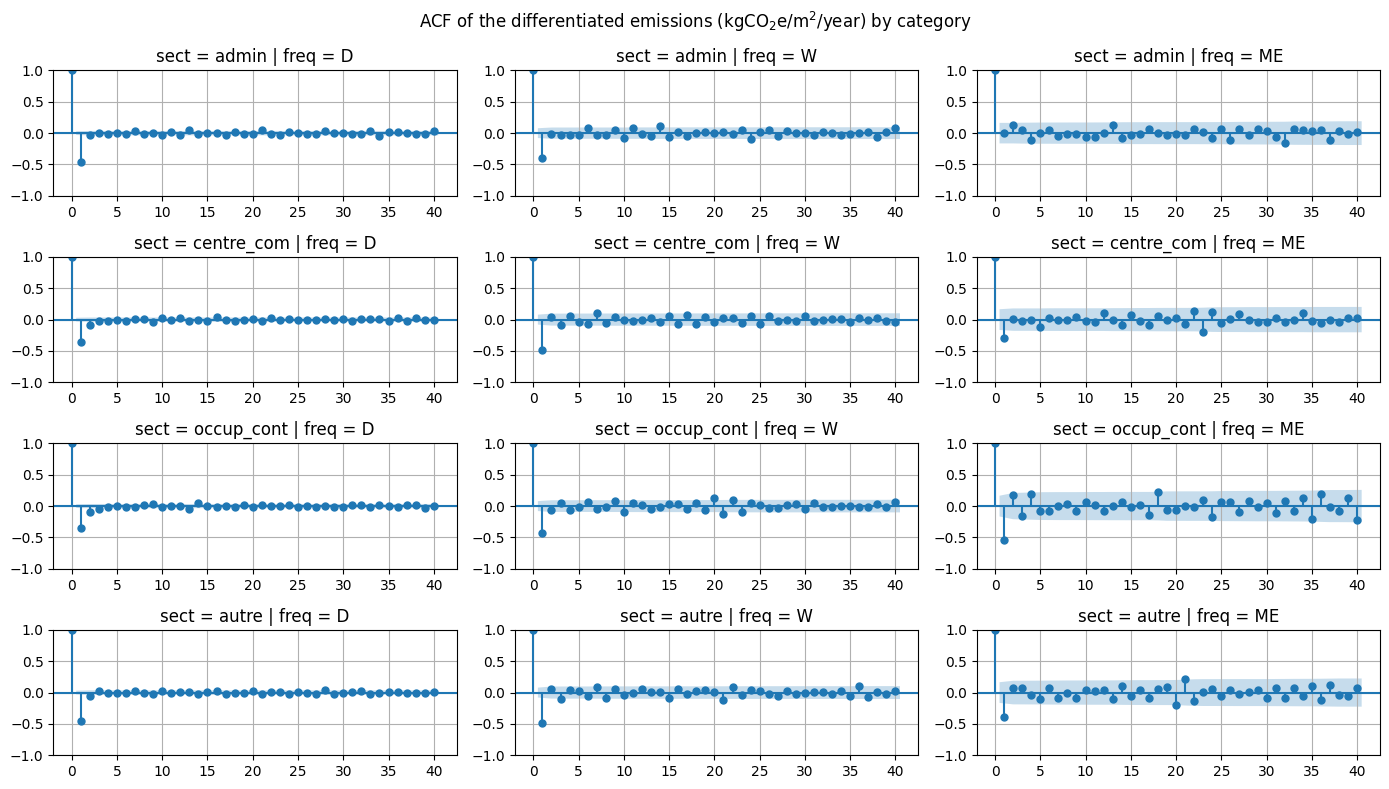

In [58]:
fig, axs = plt.subplots(4, 3, figsize=(14, 8))

for i, sect in enumerate(ts_diff):
    for j, freq in enumerate(ts_diff[sect]):
        plot_acf(ts_diff[sect][freq], ax=axs[i, j], lags=40)
        axs[i, j].set_title(f'sect = {sect} | freq = {freq}')
        axs[i, j].grid(True)

fig.suptitle('ACF of the differentiated emissions (kgCO$_2$e/m$^2$/year) by category')
plt.tight_layout()
plt.show()

The ACF plots indicate that the parameter $q$ should be $1$ (or $2$ at most). As only for the first lag do we see a large correlation.

## Model testing

Based on the previous analysis, we choose to test the following models:
- _ARIMA(0, 1, 1)_
- _ARIMA(0, 1, 2)_ 
- _ARIMA(1, 1, 1)_

In [ ]:
orders = [(0, 1, 1), (0, 1, 2), (1, 1, 1)]
model_fits = {}

for sect in ts_diff:
    model_fits[sect] = {}
    for freq in ts_diff[sect]:
        model_fits[sect][freq] = {}
        for order in orders:
            model = ARIMA(ts[sect][freq], order=order)
            model_fit = model.fit()
            model_fits[sect][freq][order] = model_fit

In [68]:
columns = pd.MultiIndex.from_tuples([(sect, freq, str(order)) for sect in model_fits for freq in model_fits[sect] for order in model_fits[sect][freq]])

comparison_admin = pd.DataFrame(
    data=[[model_fits[sect][freq][order].aic for sect in model_fits for freq in model_fits[sect] for order in model_fits[sect][freq]], 
          [model_fits[sect][freq][order].bic for sect in model_fits for freq in model_fits[sect] for order in model_fits[sect][freq]]], 
    columns=columns, 
    index=['AIC', 'BIC']
    )

### For `admin`

In [69]:
comparison_admin.loc[:, 'admin']

D                                        W               \
        (0, 1, 1)     (0, 1, 2)     (1, 1, 1)    (0, 1, 1)    (0, 1, 2)   
AIC  23492.781390  23469.833438  23469.849992  2479.722560  2477.895213   
BIC  23505.548256  23488.983738  23489.000292  2488.598063  2491.208468   

                          ME                          
       (1, 1, 1)   (0, 1, 1)   (0, 1, 2)   (1, 1, 1)  
AIC  2477.180100  452.650540  450.327876  453.586564  
BIC  2490.493355  458.576229  459.216410  462.475098

Best models for `admin`:
- D:  (0, 1, 2)
- W:  (1, 1, 1)
- ME: (0, 1, 2)

In [73]:
best_fits = {}
best_fits['admin'] = {'D': model_fits['admin']['D'][(0, 1, 2)], 
                      'W': model_fits['admin']['W'][(1, 1, 1)], 
                      'ME': model_fits['admin']['ME'][(0, 1, 2)]}

### For `centre_com`

In [70]:
comparison_admin.loc[:, 'centre_com']

D                                        W               \
        (0, 1, 1)     (0, 1, 2)     (1, 1, 1)    (0, 1, 1)    (0, 1, 2)   
AIC  25165.525457  24824.424485  24769.003659  2916.837939  2916.931834   
BIC  25178.249341  24843.510311  24788.089485  2925.671403  2930.182031   

                          ME                          
       (1, 1, 1)   (0, 1, 1)   (0, 1, 2)   (1, 1, 1)  
AIC  2916.522807  541.291084  539.933661  537.358400  
BIC  2929.773004  547.174369  548.758588  546.183327

Best models for `centre_com`:
- D:  (1, 1, 1)
- W:  (1, 1, 1)
- ME: (1, 1, 1)

In [78]:
best_fits['centre_com'] = {'D': model_fits['centre_com']['D'][(1, 1, 1)], 
                      'W': model_fits['centre_com']['W'][(1, 1, 1)], 
                      'ME': model_fits['centre_com']['ME'][(1, 1, 1)]}

### For `occup_cont`

In [71]:
comparison_admin.loc[:, 'occup_cont']

D                                        W               \
        (0, 1, 1)     (0, 1, 2)     (1, 1, 1)    (0, 1, 1)    (0, 1, 2)   
AIC  26292.720513  25943.460833  25863.936850  3119.351458  3115.982627   
BIC  26305.437845  25962.536832  25883.012849  3128.178376  3129.223004   

                          ME                          
       (1, 1, 1)   (0, 1, 1)   (0, 1, 2)   (1, 1, 1)  
AIC  3116.109058  582.875165  583.488844  582.012536  
BIC  3129.349434  588.758450  592.313771  590.837464

Best models for `occup_cont`:
- D:  (1, 1, 1)
- W:  (0, 1, 2)
- ME: (1, 1, 1)

In [79]:
best_fits['occup_cont'] = {'D': model_fits['occup_cont']['D'][(1, 1, 1)], 
                      'W': model_fits['occup_cont']['W'][(0, 1, 2)], 
                      'ME': model_fits['occup_cont']['ME'][(1, 1, 1)]}

### For `autre`

In [72]:
comparison_admin.loc[:, 'autre']

D                                        W               \
        (0, 1, 1)     (0, 1, 2)     (1, 1, 1)    (0, 1, 1)    (0, 1, 2)   
AIC  24069.620899  24041.075534  24040.837139  2439.168721  2440.762380   
BIC  24082.352709  24060.173249  24059.934854  2448.008711  2454.022364   

                          ME                          
       (1, 1, 1)   (0, 1, 1)   (0, 1, 2)   (1, 1, 1)  
AIC  2440.707757  457.991888  457.544372  457.442165  
BIC  2453.967742  463.889408  466.390652  466.288444

Best models for `autre`:
- D:  (1, 1, 1)
- W:  (0, 1, 1)
- ME: (1, 1, 1)

In [76]:
best_fits['autre'] = {'D': model_fits['autre']['D'][(1, 1, 1)], 
                      'W': model_fits['autre']['W'][(0, 1, 1)], 
                      'ME': model_fits['autre']['ME'][(1, 1, 1)]}

## Residual analysis

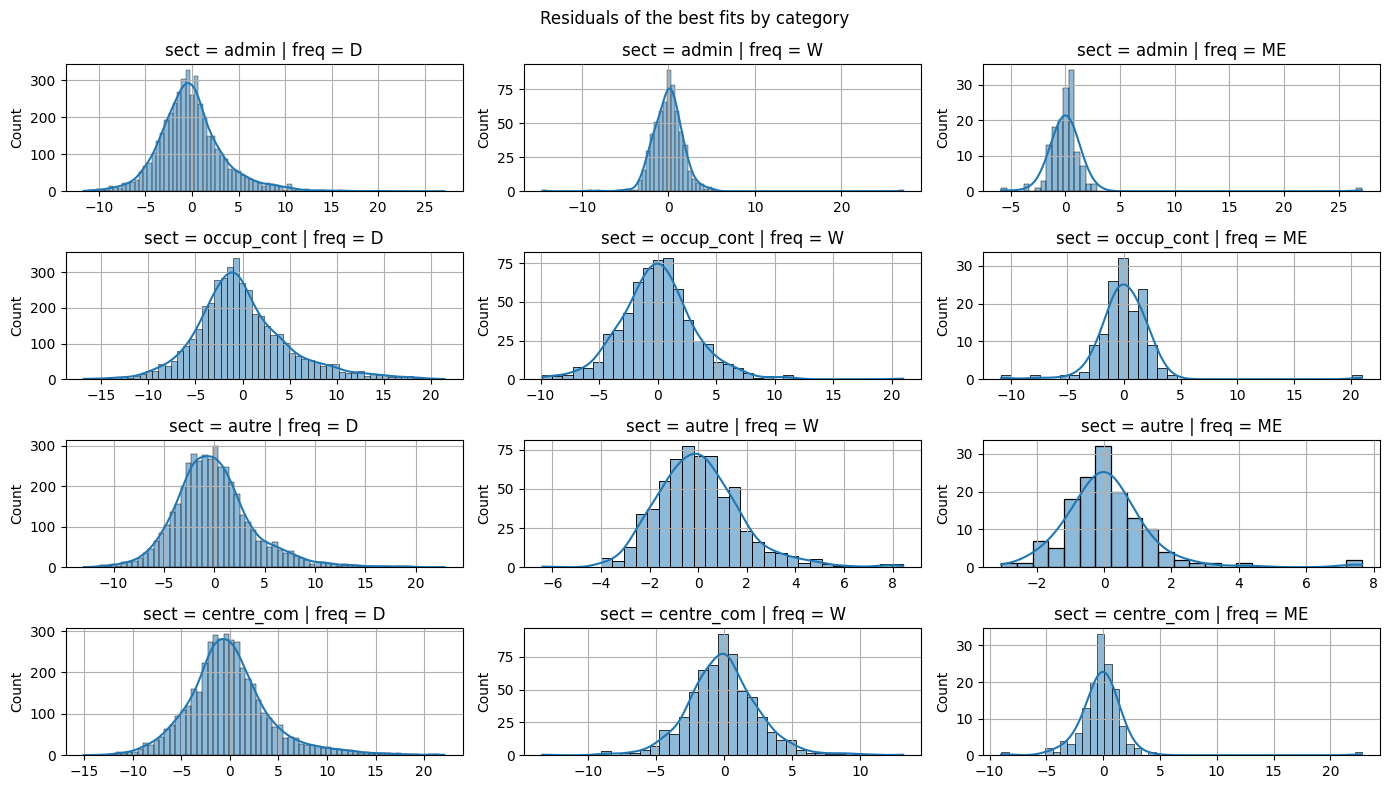

In [82]:
fig, axs = plt.subplots(4, 3, figsize=(14, 8))

for i, sect in enumerate(best_fits):
    for j, freq in enumerate(best_fits[sect]):
        sns.histplot(best_fits[sect][freq].resid, kde=True, ax=axs[i, j])
        axs[i, j].set_title(f'sect = {sect} | freq = {freq}')
        axs[i, j].grid(True)

fig.suptitle('Residuals of the best fits by category')
plt.tight_layout()
plt.show()

All the residuals seem to have a normal distribution with a mean very close to 0, which is in favor of the robustness of our models.

## Prediction and validation

For this part, to avoid redundancy, we will only apply the best model fit for the category `admin` for a weekly (`W`) frequency.

In [141]:
train, test = ttsplit(ts['admin']['W'], test_size=0.25)

In [142]:
model = ARIMA(endog=train, order=(0, 1, 2))
model_fit = model.fit()
pred = model_fit.forecast(steps=len(test))

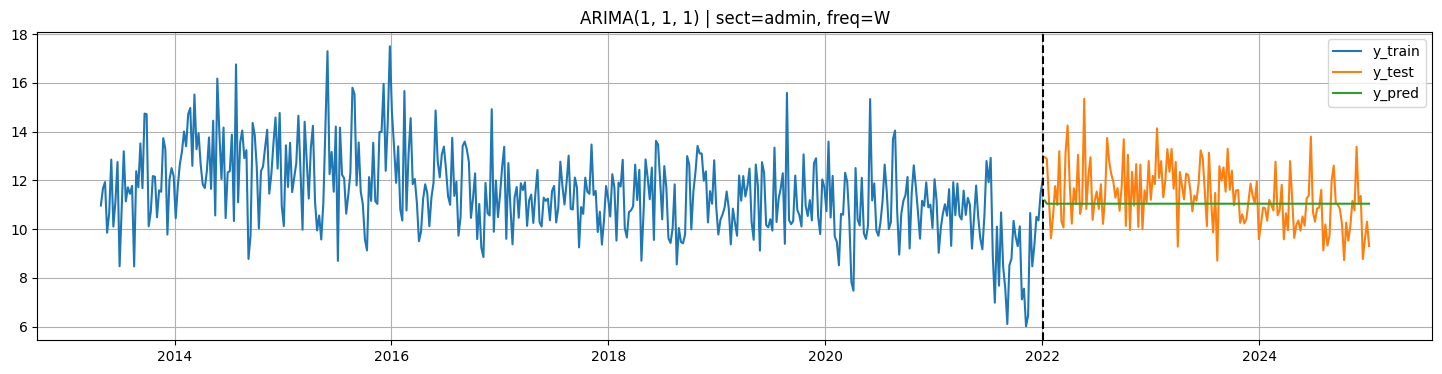

In [152]:
n = len(test)

fig = plt.figure(figsize=(18, 4))

plt.plot(train.iloc[15:], label='y_train')
plt.plot(test, label='y_test')
plt.plot(test.index, pred, label='y_pred')
plt.axvline(x = train.index[-1], color='black', linestyle='--')

plt.grid(True)
plt.legend()
plt.title(f'ARIMA(1, 1, 1) | sect=admin, freq=W')
plt.show()

In [153]:
rmse = mean_squared_error(y_true=test, y_pred=pred)
print(f'RMSE: {rmse:.2f}')

RMSE: 1.57


These _mediocre_ results were expected for a simple model like _ARIMA_.